# MIRI FQPM 1550 Observations of Fomalhaut 

Here we create the basics for a MIRI simulation to observe the Fomalhaut system with the FQPM 1550. This includes simulating the Fomalhaut stellar source behind the center of the phase mask, some fake off-axis companions, and a debris disk model that crosses the mask's quadrant boundaries.

From JWST PID 1193, the pointing file provides some the relevant information. Here's a truncated version of the pointing file for the first roll position. In this example, we skip the target acquisition observations and only simulate the science exposure image.
```
* Fomalhaut-1550C-Rot1 (Obs 6)
** Visit 6:1
Aperture Name     Target        RA        Dec         V2       V3      IdlX    IdlY   Level    Type 
MIRIM_TABLOCK     3 FOMALHAU  +344.41269 -29.62224  -407.464 -387.100  +0.000  +0.000 TARGET   T_ACQ 
MIRIM_TA1550_UR   3 FOMALHAU  +344.41269 -29.62224  -395.471 -365.842  +0.000  +0.000 TARGET   T_ACQ 
MIRIM_TA1550_CUR  3 FOMALHAU  +344.41269 -29.62224  -391.430 -370.519  +0.122  +0.134 TARGET   T_ACQ 
MIRIM_MASK1550    3 FOMALHAU  +344.41269 -29.62224  -389.892 -372.181  +0.000  +0.000 TARGET   SCIENCE 
```

Final outputs will be detector-sampled slope images (counts/sec).

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import webbpsf_ext, pysiaf
from astropy.io import fits

In [3]:
from webbpsf_ext import image_manip, setup_logging

# MIRI Observation with FQPM1550

## Create PSF structure

In [4]:
# Mask information
mask_id = '1550'
filt = f'F{mask_id}C'
mask = f'FQPM{mask_id}'
pupil = 'MASKFQPM'

# Initiate instrument class with selected filters, pupil mask, and image mask
inst = webbpsf_ext.MIRI_ext(filter=filt, pupil_mask=pupil, image_mask=mask)

[   webbpsf:INFO] MIRI SIAF aperture name updated to MIRIM_FULL
[   webbpsf:INFO] MIRI SIAF aperture name updated to MIRIM_CORON1550


In [5]:
# Set desired PSF size and oversampling
inst.fov_pix = 256
inst.oversample = 2

In [6]:
# Calculate PSF coefficients
inst.gen_psf_coeff()

[webbpsf_ext:INFO] Loading /Users/Jarron/NIRCam/webbpsf_ext_data/psf_coeffs/MIRI/F1550C_MASKFQPM_FQPM1550_pix256_os2_jsig0_r0.00_th+0.0_RevWslice0_distort_legendre.fits


In [7]:
# Calculate position-dependent PSFs due to FQPM
# Equivalent to generating a giant library to interpolate over
inst.gen_wfemask_coeff()

[webbpsf_ext:INFO] Loading /Users/Jarron/NIRCam/webbpsf_ext_data/psf_coeffs/MIRI/F1550C_MASKFQPM_FQPM1550_pix256_os2_jsig0_r0.00_th+0.0_RevWslice0_distort_legendre_wfemask.npz


## Observation setup

__Configuring observation settings__

Observations consist of nested visit, mosaic tiles, exposures, and dithers. In this section, we configure a pointing class that houses information for a single observation defined in the APT .pointing file. The primary information includes a pointing reference SIAF aperturne name, RA and Dec of the ref aperture, Base X/Y offset relative to the ref aperture position, and Dith X/Y offsets. From this information, along with the V2/V3 position angle, we can determine the orientation and location of objects on the detector focal plane.

**Note**: The reference aperture is not necessarily the same as the observed aperture. For instance, you may observe simultaneously with four of NIRCam's SWA detectors, so the reference aperture would be the entire SWA channel, while the observed apertures are A1, A2, A3, and A4.

In [8]:
# Import class to setup pointing info
from webbpsf_ext.coords import jwst_point

In [9]:
# Observed and reference apertures
ap_obs = inst.aperturename
ap_ref = 'MIRIM_MASK1550'
    
# Define the RA/Dec of reference aperture and telescope position angle
# Position angle is angle of V3 axis rotated towards East
ra_ref, dec_ref = (+344.41269, -29.62224)
pos_ang = 30

# Set any baseline pointing offsets (e.g., specified in APT's Special Requirements)
base_offset=(0,0)
# Define a list of nominal dither offsets
dith_offsets = [(0,0)]

# Telescope pointing information
tel_point = jwst_point(ap_obs, ap_ref, ra_ref, dec_ref, pos_ang=pos_ang,
                       base_offset=base_offset, dith_offsets=dith_offsets)

[webbpsf_ext:INFO] Generating random pointing offsets...
[webbpsf_ext:INFO] Pointing uncertainty: 5.0 mas
[webbpsf_ext:INFO]   Pos 0 dither uncertainty: 0.0 mas


In [10]:
print(f"Reference aperture: {tel_point.siaf_ap_ref.AperName}")
print(f"  Nominal RA, Dec = ({tel_point.ra_ref:.6f}, {tel_point.dec_ref:.6f})")
print(f"Observed aperture: {tel_point.siaf_ap_obs.AperName}")
print(f"  Nominal RA, Dec = ({tel_point.ra_obs:.6f}, {tel_point.dec_obs:.6f})")

print(f"Relative offsets in 'idl' for each dither position (incl. pointing errors)")
for i, offset in enumerate(tel_point.position_offsets_act):
    print(f"  Position {i}: ({offset[0]:.4f}, {offset[1]:.4f}) arcsec")

Reference aperture: MIRIM_MASK1550
  Nominal RA, Dec = (344.412690, -29.622240)
Observed aperture: MIRIM_CORON1550
  Nominal RA, Dec = (344.412690, -29.622240)
Relative offsets in 'idl' for each dither position (incl. pointing errors)
  Position 0: (-0.0087, 0.0025) arcsec


## Add central source

Here we define the stellar atmosphere parameters for Fomalhaut, including spectral type, optional values for (Teff, log_g, metallicity), normalization flux and bandpass, as well as RA and Dec.

In [11]:
from webbpsf_ext import miri_filter, nircam_filter, bp_2mass
from webbpsf_ext.image_manip import pad_or_cut_to_size

def make_spec(name=None, sptype=None, flux=None, flux_units=None, bp_ref=None, **kwargs):
    """
    Create pysynphot stellar spectrum from input dictionary properties.
    """

    from webbpsf_ext import stellar_spectrum
    
    # Renormalization arguments
    renorm_args = (flux, flux_units, bp_ref)
    
    # Create spectrum
    sp = stellar_spectrum(sptype, *renorm_args, **kwargs)
    if name is not None:
        sp.name = name
    
    return sp

In [12]:
# Information necessary to create pysynphot spectrum of star
obj_params = {
    'name': 'Fomalhaut', 
    'sptype': 'A4V', 
    'Teff': 8760, 'log_g': 4.2, 'metallicity': 0, # Di Folco, et al. (2004)
    'dist': 7.7,
    # 'flux': 1.05, 'flux_units': 'vegamag', 'bp_ref': bp_2mass('k'),
    'flux': 6.79, 'flux_units': 'Jy', 'bp_ref': miri_filter('F1550C'),
    'RA_obj'  : +344.41269,  # RA (decimal deg) of source
    'Dec_obj' :  -29.62224,  # Dec (decimal deg) of source
}

In [13]:
# Create stellar spectrum and add to dictionary
sp_star = make_spec(**obj_params)
obj_params['sp'] = sp_star

In [14]:
# Get `sci` coord positions
coord_obj = (obj_params['RA_obj'], obj_params['Dec_obj'])
xsci, ysci = tel_point.radec_to_frame(coord_obj, frame_out='sci')

# Get sci position shifts from center in units of detector pixels
siaf_ap = tel_point.siaf_ap_obs
xsci_cen, ysci_cen = siaf_ap.reference_point('sci')
xsci_off, ysci_off = (xsci-xsci_cen, ysci-ysci_cen)

# and now oversampled pixel shifts
osamp = inst.oversample
xsci_off_over = xsci_off * osamp
ysci_off_over = ysci_off * osamp

print("Image shifts (oversampled pixels):", xsci_off_over, ysci_off_over)

Image shifts (oversampled pixels): -0.1572616216862741 0.04521935868268656


In [15]:
# Create PSF
# PSFs already includes geometric distortions based on SIAF info
sp = obj_params['sp']
hdul = inst.calc_psf_from_coeff(sp=sp, coord_vals=(xsci,ysci), coord_frame='sci')

# Expand PSF to full frame and offset to proper position
ny_pix, nx_pix = (siaf_ap.YSciSize, siaf_ap.XSciSize)
ny_pix_over, nx_pix_over = np.array([ny_pix, nx_pix]) * osamp
shape_new = (ny_pix*osamp, nx_pix*osamp)
delyx = (ysci_off_over, xsci_off_over)
image_full = pad_or_cut_to_size(hdul[0].data, shape_new, offset_vals=delyx)

# Make new HDUList of target (just central source so far)
hdul_full = fits.HDUList(fits.PrimaryHDU(data=image_full, header=hdul[0].header))

[webbpsf_ext:INFO] Generating mask-dependent modifications...


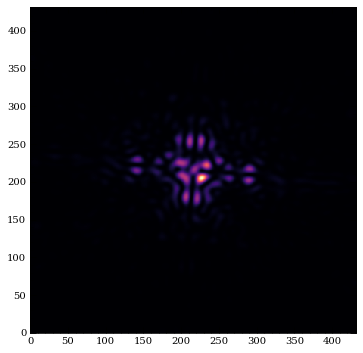

In [16]:
plt.imshow(hdul_full[0].data, cmap='magma')

## Add companions

This section demonstrates four difference ways to specify atmospheric parameters for generating companion spectrum:
 1. Using Spiegel & Burrows (2012) exoplanet atmsophere models
 2. BEX models from Linder et al. (2019)
 3. AMES-Cond models (Allard et al. 2001, Baraffe et al. 2003)
 4. BOSZ stellar spectrum (Bohlin et al. 2017)
 
Since the BEX and COND model grids only supply observed magnitudes within particular JWST instrument bands, an SED is supplied from SB12 (of similar mass) in order to produce a reasonable spectral shape. Otherwise, a flat spectrum would be used during the PSF generation, which may not be a fair representation of the flux weighting across a given bandpass.

For locations, we also supply position offsets to the primary component, rather than requesting the absolute RA/Dec. 

In [17]:
from webbpsf_ext import spectra, coords
from webbpsf_ext.utils import S

In [18]:
# Information for hypothetical companions surrounding Fomalhaut


# Example using Spiegel & Burrows (2012) exoplanet atmsophere models
comp_SB12_params = {
    'name': 'Fom_b',
    'xy_off': None, 'rth_off': (50, -45), 'runits': 'AU', # 'AU' or 'asec'
    'model': 'SB12', # 'SB12', 'BEX', 'cond', or stellar ('bosz', 'ck04models', 'phoenix')
    'mass': 10, 'age': 440, 'dist': 7.7,  # MJup, Myr, pc
    'atmo': 'hy3s', 'entropy': 10,       # SB12-specific atmosphere model
    'accr': False, 'mmdot': None, 'mdot': None, 'accr_rin': 2, 'truncated':False,
    'sptype': None, 'Av':0, 'renorm_args': None, 
}

# Example using BEX models (Linder et al. 2019)
comp_BEX_params = {
    'name': 'Fom_c',
    'xy_off': None, 'rth_off': (50,+45), 'runits': 'AU', # 'AU' or 'asec'
    'model': 'BEX', # 'SB12', 'BEX', 'cond', or stellar ('bosz', 'ck04models', 'phoenix')
    'mass': 10, 'age': 440, 'dist': 7.7,
    'accr': False, 'mmdot': None, 'mdot': None, 'accr_rin': 2, 'truncated':False,
    'sptype': None, 'Av':0, 'renorm_args': None, 
}

# Example using AMES-Cond models (Allard et al. 2001, Baraffe et al. 2003)
comp_cond_params = {
    'name': 'Fom_d',
    'xy_off': None, 'rth_off': (50,+135), 'runits': 'AU', # 'AU' or 'asec'
    'model': 'cond', # 'SB12', 'BEX', 'cond', or stellar ('bosz', 'ck04models', 'phoenix')
    'mass': 10, 'age': 440, 'dist': 7.7,
    'accr': False, 'mmdot': None, 'mdot': None, 'accr_rin': 2, 'truncated':False,
    'sptype': None, 'Av':0, 'renorm_args': None, 
}

# Example using BOSZ stellar spectrum (Bohlin et al. 2017)
comp_star_params = {
    'name': 'Fom_e',
    'xy_off': None, 'rth_off': (10,-135), 'runits': 'asec', # 'AU' or 'asec'
    'model': 'bosz', # 'SB12', 'BEX', 'cond', or stellar ('bosz', 'ck04models', 'phoenix')
    'sptype': 'M0V', 'Av':0, 'renorm_args': (10,'vegamag',inst.bandpass), 
}


In [19]:
# All companion params
comp_parms_all = [comp_SB12_params, comp_BEX_params, comp_cond_params, comp_star_params]

# Create spectrum for each source
bp = inst.bandpass
for kwargs in comp_parms_all:
    sp = spectra.companion_spec(bp, **kwargs)
    kwargs['sp'] = sp
    
    # Anticipated magnitude in instrument bandpass
    obs = S.Observation(sp, bp, binset=bp.wave)
    mag = obs.effstim('vegamag')
    print(f"  {kwargs['name']} in {bp.name}: {mag:.2f} mag")


[webbpsf_ext:WARNING] Overlap between spectrum and bandpass: partial.
[webbpsf_ext:WARNING] Recommend supplying renorm_args input.


  Fom_b in F1550C: 11.03 mag
  Fom_c in F1550C: 11.05 mag
  Fom_d in F1550C: 10.83 mag
  Fom_e in F1550C: 10.00 mag


In [20]:
# Add RA/Dec positions for each source
ra_obj, dec_obj = (obj_params['RA_obj'], obj_params['Dec_obj'])
for comp_params in comp_parms_all:
    if comp_params['rth_off'] is None:
        x, y = comp_params['xy_off']
        r, th = xy_to_rtheta(x,y)
    else:
        r, th = comp_params['rth_off']
    
    runits = comp_params['runits']
    if 'AU' in runits:
        r_asec = r / obj_params['dist']
    elif ('asec' in runits) or ('arcsec' in runits):
        r_asec = r
    else:
        errstr = "Do not recognize runits='{}'".format(runits)
        raise ValueError(errstr)
    
    ra, dec = coords.radec_offset(ra_obj, dec_obj, r_asec, th)
    comp_params['RA_obj']  = ra
    comp_params['Dec_obj'] = dec


In [21]:
siaf_ap = tel_point.siaf_ap_obs
xsci_cen, ysci_cen = siaf_ap.reference_point('sci')

xsci_all = []
ysci_all = []
yxsci_off_all = []
for comp_params in comp_parms_all:
    # Get `sci` coord positions
    coord_obj = (comp_params['RA_obj'], comp_params['Dec_obj'])
    xsci, ysci = tel_point.radec_to_frame(coord_obj, frame_out='sci')
    xsci_all.append(xsci)
    ysci_all.append(ysci)

    # Get sci position shifts from center in units of detector pixels
    xsci_off, ysci_off = (xsci-xsci_cen, ysci-ysci_cen)

    # and oversampled pixel shifts
    osamp = inst.oversample
    xsci_off_over = xsci_off * osamp
    ysci_off_over = ysci_off * osamp
    yxsci_off_all.append([ysci_off_over, xsci_off_over])

    print(f"Sci pixels offset = ({xsci_off_over:+7.2f}, {ysci_off_over:+7.2f})")

Sci pixels offset = (+115.70,  +20.32)
Sci pixels offset = ( -21.68, +115.38)
Sci pixels offset = (-115.98,  -20.18)
Sci pixels offset = ( +32.87, -177.44)


In [22]:
# Create PSF for each companion
sp_all = [d['sp'] for d in comp_parms_all]
coord_vals = np.array((xsci_all,ysci_all))
hdul = inst.calc_psf_from_coeff(sp=sp_all, coord_vals=coord_vals, coord_frame='sci')

# Expand PSF to full frame and offset to proper position
ny_pix, nx_pix = (siaf_ap.YSciSize, siaf_ap.XSciSize)
ny_pix_over, nx_pix_over = np.array([ny_pix, nx_pix]) * osamp
shape_new = (ny_pix*osamp, nx_pix*osamp)
image_companion_full = np.zeros(shape_new, dtype='float')

# Offset and sum images together
for i, hdu in enumerate(hdul):
    # Offsets are passed as (dely, delx)
    delyx = yxsci_off_all[i]
    image_companion_full += pad_or_cut_to_size(hdu.data, shape_new, offset_vals=delyx)
    
# Add to final HDUList
hdul_full[0].data += image_companion_full

[webbpsf_ext:INFO] Generating mask-dependent modifications...


PSFs:   0%|          | 0/4 [00:00<?, ?it/s]

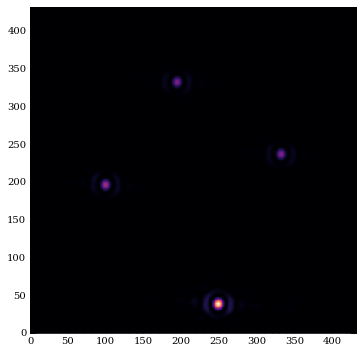

In [23]:
plt.imshow(image_companion_full, cmap='magma')

## Convolve extended disk image

Properly including extended objects is a little more complicated than for point sources. First, we need properly format the input model to a pixel binning and flux units appropriate for the simulations (ie., pixels should be equal to oversampled PSFs with flux units of counts/sec). Then, the image needs to be rotated relative to the 'idl' coordinate plane and subsequently shifted for any pointing offsets. Once in the appropriate 'idl' system 


In [24]:
# Create grid locations for array of PSFs to generate
apname = inst.psf_coeff_header['APERNAME']
siaf_ap = inst.siaf[apname]

field_rot = 0 if inst._rotation is None else inst._rotation

xyoff_half = 10**(np.linspace(-2,1,10))
xoff = yoff = np.concatenate([-1*xyoff_half[::-1],[0],xyoff_half])

# Mask Offset grid positions in arcsec
xgrid_off, ygrid_off = np.meshgrid(xoff, yoff)
xgrid_off, ygrid_off = xgrid_off.flatten(), ygrid_off.flatten()

# Science positions in detector pixels
xoff_sci_asec, yoff_sci_asec = coords.xy_rot(-1*xgrid_off, -1*ygrid_off, -1*field_rot)
xsci = xoff_sci_asec / siaf_ap.XSciScale + siaf_ap.XSciRef
ysci = yoff_sci_asec / siaf_ap.YSciScale + siaf_ap.YSciRef

In [25]:
%%time

# Now, create all PSFs, one for each (xsci, ysci) location
# Only need to do this once 
hdul_psfs = inst.calc_psf_from_coeff(coord_vals=(xsci, ysci), coord_frame='sci', return_oversample=True)

[webbpsf_ext:INFO] Generating mask-dependent modifications...


PSFs:   0%|          | 0/441 [00:00<?, ?it/s]

CPU times: user 1min 6s, sys: 15.5 s, total: 1min 21s
Wall time: 43.4 s


In [26]:
# Disk model information
disk_params = {
    'file': "Fomalhaut/Fomalhaut_F1550Csc.fits",
    'pixscale': 0.02775,
    'wavelength': 15.5,
    'units': 'Jy/pixel',
    'dist' : 7.7,
    'cen_star' : False,
}

# Open model and rebin to PSF sampling
# Scale to instrument wavelength assuming grey scattering function
# Converts to phot/sec/lambda
hdul_disk_model = image_manip.make_disk_image(inst, disk_params, sp_star=obj_params['sp'])

# Rotation necessary to go from sky coordinates to 'idl' frame
rotate_to_idl = -1*(tel_point.siaf_ap_obs.V3IdlYAngle + tel_point.pos_ang)

In [27]:
# Select the first dither location offset
delx, dely = tel_point.position_offsets_act[0]
hdul_out = image_manip.rotate_shift_image(hdul_disk_model, PA_offset=rotate_to_idl,
                                          delx_asec=delx, dely_asec=dely)

# Distort image on 'sci' coordinate grid
im_sci, xsci_im, ysci_im = image_manip.distort_image(hdul_out, ext=0, to_frame='sci', return_coords=True)

# Distort image onto 'tel' (V2, V3) coordinate grid for plot illustration
im_tel, v2_im, v3_im = image_manip.distort_image(hdul_out, ext=0, to_frame='tel', return_coords=True)

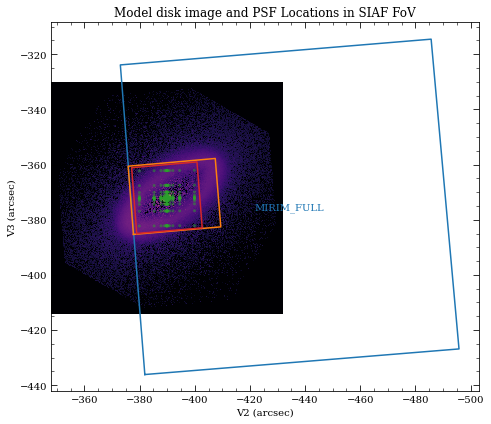

In [28]:
# Plot locations for PSFs that we will generate
fig, ax = plt.subplots(1,1)

# Show image in V2/V3 plane
extent = [v2_im.min(), v2_im.max(), v3_im.min(), v3_im.max()]
ax.imshow(im_tel**0.1, extent=extent, cmap='magma')

# Add on SIAF aperture boundaries
tel_point.plot_inst_apertures(ax=ax, clear=False, label=True)
tel_point.plot_ref_aperture(ax=ax)
tel_point.plot_obs_aperture(ax=ax, color='C3')

# Add PSF location points
v2, v3 = siaf_ap.convert(xsci, ysci, 'sci', 'tel')
ax.scatter(v2, v3, marker='.', alpha=0.5, color='C2', edgecolors='none', linewidths=0)

ax.set_title('Model disk image and PSF Locations in SIAF FoV')

fig.tight_layout()

This particular disk image is oversized, so we will need to crop the image after convolving PSFs. We may want to consider trimming some of this image prior to convolution, depending on how some of the FoV is blocked before reaching the coronagraphic optics.

In [29]:
# If the image is too large, then this process will eat up much of your computer's RAM
# So, crop image to more reasonable size (20% oversized)
osamp = inst.oversample
xysize = int(1.2 * np.max([siaf_ap.XSciSize,siaf_ap.YSciSize]) * osamp)
xy_add = osamp - np.mod(xysize, osamp)
xysize += xy_add

im_sci = pad_or_cut_to_size(im_sci, xysize)
hdul_disk_model_sci = fits.HDUList(fits.PrimaryHDU(data=im_sci, header=hdul_out[0].header))

# Convolve image
im_conv = image_manip.convolve_image(hdul_disk_model_sci, hdul_psfs)

  0%|          | 0/441 [00:00<?, ?it/s]

Closing multiprocess pool.


In [30]:
# Add cropped image to final oversampled image
im_conv = pad_or_cut_to_size(im_conv, hdul_full[0].data.shape)
hdul_full[0].data += im_conv

In [31]:
def quick_ref_psf(idl_coord, inst, out_shape, sp=None):
    """
    Create a quick reference PSF for subtraction of the science target.
    """
    
    # Observed SIAF aperture
    siaf_ap = tel_point.siaf_ap_obs
    
    # Location of observation
    xidl, yidl = idl_coord
    
    # Get offset in SCI pixels
    xsci_off, ysci_off = np.array(siaf_ap.convert(xidl, yidl, 'idl', 'sci')) - \
                         np.array(siaf_ap.reference_point('sci'))
    
    # Get oversampled pixels offests
    osamp = inst.oversample
    xsci_off_over, ysci_off_over = np.array([xsci_off, ysci_off]) * osamp
    yx_offset = (ysci_off_over, xsci_off_over)
    
    # Create PSF
    prev_log = webbpsf_ext.conf.logging_level
    setup_logging('WARN', verbose=False)
    hdul_psf_ref = inst.calc_psf_from_coeff(sp=sp, coord_vals=(xidl, yidl), coord_frame='idl')
    setup_logging(prev_log, verbose=False)

    im_psf = pad_or_cut_to_size(hdul_psf_ref[0].data, out_shape, offset_vals=yx_offset)

    return im_psf

In [34]:
# Rebin science data to detector pixels
im_sci = image_manip.frebin(hdul_full[0].data, scale=1/osamp)

# Subtract a reference PSF from the science data
coord_vals = tel_point.position_offsets_act[0]
im_psf = quick_ref_psf(coord_vals, inst, hdul_full[0].data.shape, sp=sp_star)
im_ref = image_manip.frebin(im_psf, scale=1/osamp)
imdiff = im_sci - im_ref

# De-rotate to sky orientation
imrot = image_manip.rotate_offset(imdiff, rotate_to_idl, reshape=False, cval=np.nan)

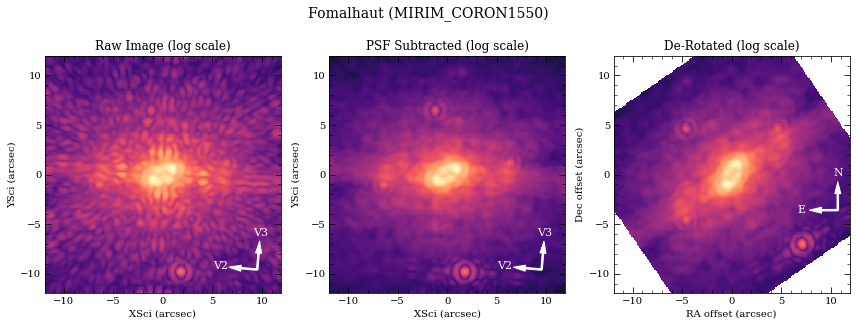

In [35]:
from matplotlib.colors import LogNorm
from webbpsf_ext.coords import plotAxes

fig, axes = plt.subplots(1,3, figsize=(12,4.5))

############################
# Plot raw image
ax = axes[0]

im = im_sci
mn = np.median(im)
std = np.std(im)
vmin = 0
vmax = mn+10*std

xsize_asec = siaf_ap.XSciSize * siaf_ap.XSciScale
ysize_asec = siaf_ap.YSciSize * siaf_ap.YSciScale
extent = [-1*xsize_asec/2, xsize_asec/2, -1*ysize_asec/2, ysize_asec/2]
norm = LogNorm(vmin=im.max()/1e5, vmax=im.max())
ax.imshow(im, extent=extent, norm=norm, cmap='magma')

ax.set_title("Raw Image (log scale)")

ax.set_xlabel('XSci (arcsec)')
ax.set_ylabel('YSci (arcsec)')
plotAxes(ax, angle=-1*siaf_ap.V3SciYAngle)

############################
# Basic PSF subtraction
# Subtract a near-perfect reference PSF
ax = axes[1]
norm = LogNorm(vmin=imdiff.max()/1e5, vmax=imdiff.max())
ax.imshow(imdiff, extent=extent, norm=norm, cmap='magma')

ax.set_title("PSF Subtracted (log scale)")

ax.set_xlabel('XSci (arcsec)')
ax.set_ylabel('YSci (arcsec)')
plotAxes(ax, angle=-1*siaf_ap.V3SciYAngle)

############################
# De-rotate to sky orientation

ax = axes[2]
ax.imshow(imrot, extent=extent, norm=norm, cmap='magma')

ax.set_title("De-Rotated (log scale)")

ax.set_xlabel('RA offset (arcsec)')
ax.set_ylabel('Dec offset (arcsec)')
plotAxes(ax, position=(0.95,0.35), label1='E', label2='N')

fig.suptitle(f"Fomalhaut ({siaf_ap.AperName})", fontsize=14)
fig.tight_layout()